In [5]:
import pandas as pd

In [6]:
# Import packages
import tensorflow.compat.v1 as tf
# Disable the default activate eager execution in TF v1.0
tf.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import KeyedVectors
import re
import gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryuska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
SAMPLE_USER=3

In [9]:
df_desc = pd.read_csv("./description-final.csv")

In [10]:
df_desc.columns = ["Title", "Description", "MovieID"]

In [9]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
movies_df.columns = ["MovieID","Title","Genres"]

In [10]:
movies_df.shape

(62423, 3)

In [12]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./ml-25m/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [14]:
# Rename the columns in the dataset
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [15]:
# Create a separate indexing column as we cannot use MovieID
movies_df['List Index'] = movies_df.index

In [16]:
# Merge movies with ratings by MovieID as foreign key
merged_df = movies_df.merge(ratings_df, on='MovieID')

In [17]:
merged_df.head()

,MovieID,Title,Genres,List Index,UserID,Rating,Timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,8,4.0,890492517


In [19]:
# Get user groups
userGroup = merged_df.groupby('UserID')

In [22]:
def preprocess_data(userGroup, movies_df):
    # No. of users in training
    UsedUsers = 1000
    # create list
    trX = []
    # for each user in the group
    for userID, curUser in userGroup:
        # Temp variable that stores every movie's rating
        temp = [0] * len(movies_df)
        # For Each movie in the curUser's movie list
        for num, movie in curUser.iterrows():
            # Divide ratings by 5 and store it
            temp[int(movie['List Index'])] = movie['Rating'] / 5

        # Now add the list of ratings into the training list
        trX.append(temp)
        # Check to see if we finished adding in the amount of users for training
        if UsedUsers == 0:
            break
        UsedUsers -= 1
    return trX

In [23]:
# Return normalized user ratings into a list
trX = preprocess_data(userGroup, movies_df)

In [24]:
def rbm(movies_df):
    n_hid = 100  # Number of hidden layers
    n_vis = len(movies_df)  # Number of visible layers

    # Create respective placeholder variables for storing visible and hidden layer biases and weights
    vb = tf.placeholder("float", [n_vis])  # Number of unique movies
    hb = tf.placeholder("float", [n_hid])  # Number of features
    W = tf.placeholder("float", [n_vis, n_hid])  # Weights that connect the hidden and visible layers

    # Pre-process the input data
    v0 = tf.placeholder("float", [None, n_vis])
    _h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

    # Reconstruct the pre-processed input data (Sigmoid and ReLU activation functions are used)
    _v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
    v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
    h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

    # Set RBM training parameters
    alpha = 0.1  # Set learning rate
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)  # Set positive gradients
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)  # Set negative gradients

    # Calculate contrastive divergence to maximize
    CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

    # Create methods to update the weights and biases
    update_w = W + alpha * CD
    update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
    update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

    # Set error function (RMSE)
    err = v0 - v1
    err_sum = tf.sqrt(tf.reduce_mean(err**2))

    # Initialize variables
    cur_w = np.zeros([n_vis, n_hid], np.float32)  # Current weight
    cur_vb = np.zeros([n_vis], np.float32)  # Current visible unit biases
    cur_hb = np.zeros([n_hid], np.float32)  # Current hidden unit biases
    prv_w = np.zeros([n_vis, n_hid], np.float32)  # Previous weight
    prv_vb = np.zeros([n_vis], np.float32)  # Previous visible unit biases
    prv_hb = np.zeros([n_hid], np.float32)  # Previous hidden unit biases

    return v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum

In [25]:
# Return variables from the RBM implementation
v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum = rbm(movies_df)

Instructions for updating:
Use `tf.cast` instead.


In [27]:
# Initialize TensorFlow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train RBM with 50 epochs and batches of size 512
nb_epoch = 50
batch_size_ = 512
errors = []

In [28]:
for i in range(nb_epoch):
    print("Current epoch: ", i)
    for start, end in zip(range(0, len(trX), batch_size_), range(batch_size_, len(trX), batch_size_)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print("Current RMSE error: ", errors[-1])

Current epoch:  0
Current RMSE error:  0.59252435
Current epoch:  1
Current RMSE error:  0.57949936
Current epoch:  2
Current RMSE error:  0.567591
Current epoch:  3
Current RMSE error:  0.5525033
Current epoch:  4
Current RMSE error:  0.539125
Current epoch:  5
Current RMSE error:  0.52446175
Current epoch:  6
Current RMSE error:  0.5069913
Current epoch:  7
Current RMSE error:  0.49106875
Current epoch:  8
Current RMSE error:  0.46936265
Current epoch:  9
Current RMSE error:  0.4488551
Current epoch:  10
Current RMSE error:  0.42518458
Current epoch:  11
Current RMSE error:  0.39883408
Current epoch:  12
Current RMSE error:  0.37085685
Current epoch:  13
Current RMSE error:  0.34282893
Current epoch:  14
Current RMSE error:  0.3161113
Current epoch:  15
Current RMSE error:  0.2957313
Current epoch:  16
Current RMSE error:  0.28351185
Current epoch:  17
Current RMSE error:  0.2747897
Current epoch:  18
Current RMSE error:  0.26851657
Current epoch:  19
Current RMSE error:  0.26405397


Text(0.5, 0, 'Number of Epochs')

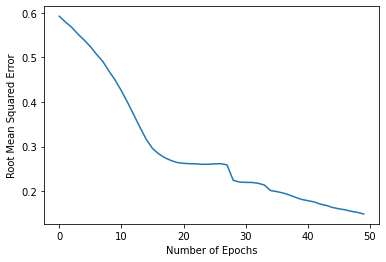

In [29]:
plt.plot(errors)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Epochs')

In [32]:
len(trX)

2501

In [30]:
# Selecting the input user
inputUser = [trX[SAMPLE_USER]]

In [35]:
# Feed in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [40]:
# We can then list the 100 most recommended movies for our mock user by sorting it by their scores given by our model
scored_movies_df_1 = movies_df
scored_movies_df_1["Recommendation Score"] = rec[0]
print("\n")
# scored_movies_df_1 = scored_movies_df_1.drop(['Title_x'],axis=1)
# scored_movies_df_1.columns = ['MovieID', 'Genres', 'Title','Description','ListIndex','Recommendation Score']
scored_movies_df_1.sort_values(["Recommendation Score"], ascending=False)


,MovieID,Title,Genres,List Index,Recommendation Score
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1.000000
1167,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,1167,1.000000
1179,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1179,1.000000
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,31,1.000000
14937,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,14937,1.000000
...,...,...,...,...,...
9065,26982,Men with Guns (1997),Drama,9065,0.012244
50137,180347,The Ages Of Lulu (1990),Drama,50137,0.012147
51878,184089,Winchester (2018),Fantasy|Horror,51878,0.012031
7253,7378,Johnson Family Vacation (2004),Comedy,7253,0.012022


In [41]:
scored_movies_df_1.shape

(62423, 5)

In [ ]:
#predicted rating

In [49]:
# Now we can find all the movies that our mock user has watched before
movies_df_1 = merged_df[merged_df['UserID'] == SAMPLE_USER]
movies_df_1

,MovieID,Title,Genres,List Index,UserID,Rating,Timestamp
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,3,4.0,1439472215
347502,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,28,3,4.5,1484754967
366079,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,31,3,4.5,1439474635
588071,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,49,3,5.0,1439474391
901250,111,Taxi Driver (1976),Crime|Drama|Thriller,109,3,4.0,1484753849
...,...,...,...,...,...,...,...
24798991,176371,Blade Runner 2049 (2017),Sci-Fi,48302,3,4.5,1566090291
24841641,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi,49883,3,3.5,1566090591
24863086,182823,Bright (2017),Action|Crime|Fantasy,51293,3,3.0,1566089510
24897465,187541,Incredibles 2 (2018),Action|Adventure|Animation|Children,53497,3,3.5,1566090693


In [50]:
userItemProfile =movies_df_1

In [51]:
userItemProfile

,MovieID,Title,Genres,List Index,UserID,Rating,Timestamp
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,3,4.0,1439472215
347502,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,28,3,4.5,1484754967
366079,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,31,3,4.5,1439474635
588071,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,49,3,5.0,1439474391
901250,111,Taxi Driver (1976),Crime|Drama|Thriller,109,3,4.0,1484753849
...,...,...,...,...,...,...,...
24798991,176371,Blade Runner 2049 (2017),Sci-Fi,48302,3,4.5,1566090291
24841641,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi,49883,3,3.5,1566090591
24863086,182823,Bright (2017),Action|Crime|Fantasy,51293,3,3.0,1566089510
24897465,187541,Incredibles 2 (2018),Action|Adventure|Animation|Children,53497,3,3.5,1566090693


In [52]:
# We merge all the movies that our mock users has watched with the predicted scores based on his historical data
merged_df_1 = scored_movies_df_1.merge(movies_df_1, on='MovieID', how='outer')
print("\n")
merged_df_1.sort_values(["Recommendation Score"], ascending=False).head(25)


,MovieID,Title_x,Genres_x,List Index_x,Recommendation Score,Title_y,Genres_y,List Index_y,UserID,Rating,Timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,3.0,4.0,1.439472e+09
1167,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,1167,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1179,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1179,1.0,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1179.0,3.0,4.0,1.439472e+09
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,31,1.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,31.0,3.0,4.5,1.439475e+09
14937,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,14937,1.0,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,14937.0,3.0,5.0,1.439474e+09
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,292,1.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,292.0,3.0,5.0,1.439474e+09
1232,1265,Groundhog Day (1993),Comedy|Fantasy|Romance,1232,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1237,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,1237,1.0,Back to the Future (1985),Adventure|Comedy|Sci-Fi,1237.0,3.0,3.5,1.439472e+09
1258,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,1258,1.0,NaN,NaN,NaN,NaN,NaN,NaN
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,257,1.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,257.0,3.0,4.0,1.439472e+09


In [53]:
merged_df_1.shape

(62423, 11)

In [54]:
userItemProfile

,MovieID,Title,Genres,List Index,UserID,Rating,Timestamp
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,3,4.0,1439472215
347502,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,28,3,4.5,1484754967
366079,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,31,3,4.5,1439474635
588071,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,49,3,5.0,1439474391
901250,111,Taxi Driver (1976),Crime|Drama|Thriller,109,3,4.0,1484753849
...,...,...,...,...,...,...,...
24798991,176371,Blade Runner 2049 (2017),Sci-Fi,48302,3,4.5,1566090291
24841641,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi,49883,3,3.5,1566090591
24863086,182823,Bright (2017),Action|Crime|Fantasy,51293,3,3.0,1566089510
24897465,187541,Incredibles 2 (2018),Action|Adventure|Animation|Children,53497,3,3.5,1566090693


In [55]:
merged_df_1.sort_values(by='Rating', ascending=False)

,MovieID,Title_x,Genres_x,List Index_x,Recommendation Score,Title_y,Genres_y,List Index_y,UserID,Rating,Timestamp
30506,136449,Ghost in the Shell 2.0 (2008),Action|Animation|Sci-Fi,30506,0.055409,Ghost in the Shell 2.0 (2008),Action|Animation|Sci-Fi,30506.0,3.0,5.0,1.484754e+09
729,745,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy,729,0.153977,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy,729.0,3.0,5.0,1.439474e+09
15479,81591,Black Swan (2010),Drama|Thriller,15479,0.176830,Black Swan (2010),Drama|Thriller,15479.0,3.0,5.0,1.492786e+09
840,858,"Godfather, The (1972)",Crime|Drama,840,1.000000,"Godfather, The (1972)",Crime|Drama,840.0,3.0,5.0,1.439474e+09
903,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,903,0.348145,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,903.0,3.0,5.0,1.439475e+09
...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,62418,0.015606,NaN,NaN,NaN,NaN,NaN,NaN
62419,209159,Window of the Soul (2001),Documentary,62419,0.016908,NaN,NaN,NaN,NaN,NaN,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,62420,0.016300,NaN,NaN,NaN,NaN,NaN,NaN
62421,209169,A Girl Thing (2001),(no genres listed),62421,0.015226,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
rbm_result = merged_df_1

In [57]:
rbm_result['UserID'] = rbm_result['UserID'].fillna(3)

In [58]:
rbm_result

,MovieID,Title_x,Genres_x,List Index_x,Recommendation Score,Title_y,Genres_y,List Index_y,UserID,Rating,Timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1.000000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,3.0,4.0,1.439472e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0.294273,NaN,NaN,NaN,3.0,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,2,0.223362,NaN,NaN,NaN,3.0,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,0.038096,NaN,NaN,NaN,3.0,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,4,0.197957,NaN,NaN,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,62418,0.015606,NaN,NaN,NaN,3.0,NaN,NaN
62419,209159,Window of the Soul (2001),Documentary,62419,0.016908,NaN,NaN,NaN,3.0,NaN,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,62420,0.016300,NaN,NaN,NaN,3.0,NaN,NaN
62421,209169,A Girl Thing (2001),(no genres listed),62421,0.015226,NaN,NaN,NaN,3.0,NaN,NaN


In [61]:
userItemProfile = userItemProfile.sort_values(by='Rating', ascending=False)
userItemProfile = userItemProfile[userItemProfile['Rating'] >= 5]
userItemProfile.shape

(32, 7)

In [62]:
df_cbf = merged_df_1[merged_df_1.isna().any(axis=1)]
df_cbf=df_cbf.drop('Rating', axis=1)

In [63]:
df_cbf

,MovieID,Title_x,Genres_x,List Index_x,Recommendation Score,Title_y,Genres_y,List Index_y,UserID,Timestamp
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0.294273,NaN,NaN,NaN,3.0,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,2,0.223362,NaN,NaN,NaN,3.0,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,0.038096,NaN,NaN,NaN,3.0,NaN
4,5,Father of the Bride Part II (1995),Comedy,4,0.197957,NaN,NaN,NaN,3.0,NaN
5,6,Heat (1995),Action|Crime|Thriller,5,0.332640,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,62418,0.015606,NaN,NaN,NaN,3.0,NaN
62419,209159,Window of the Soul (2001),Documentary,62419,0.016908,NaN,NaN,NaN,3.0,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,62420,0.016300,NaN,NaN,NaN,3.0,NaN
62421,209169,A Girl Thing (2001),(no genres listed),62421,0.015226,NaN,NaN,NaN,3.0,NaN


In [64]:
df_cbf = df_cbf.sort_values(by='Recommendation Score', ascending=False)

In [65]:
df_cbf

,MovieID,Title_x,Genres_x,List Index_x,Recommendation Score,Title_y,Genres_y,List Index_y,UserID,Timestamp
452,457,"Fugitive, The (1993)",Thriller,452,1.000000,NaN,NaN,NaN,3.0,NaN
1167,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,1167,1.000000,NaN,NaN,NaN,3.0,NaN
1640,1704,Good Will Hunting (1997),Drama|Romance,1640,1.000000,NaN,NaN,NaN,3.0,NaN
359,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,359,1.000000,NaN,NaN,NaN,3.0,NaN
46,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,46,1.000000,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9065,26982,Men with Guns (1997),Drama,9065,0.012244,NaN,NaN,NaN,3.0,NaN
50137,180347,The Ages Of Lulu (1990),Drama,50137,0.012147,NaN,NaN,NaN,3.0,NaN
51878,184089,Winchester (2018),Fantasy|Horror,51878,0.012031,NaN,NaN,NaN,3.0,NaN
7253,7378,Johnson Family Vacation (2004),Comedy,7253,0.012022,NaN,NaN,NaN,3.0,NaN


In [68]:

def _removeNonAscii(s):
    return "".join(i.encode('ascii', 'ignore').decode() for i in s )

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

def delete year(words):
    words = string.split()  # Split the string into a list of words
    new_words = words[:-1]  # Remove the last word (which should be the year)
    new_string = " ".join(new_words)  # Join the remaining words back into a string
    print(new_string)  # Output: "Fugitive, The"

In [71]:
df_cbf['Cleaned'] = df_cbf['Description'].apply(_removeNonAscii)

df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = make_lower_case)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = remove_stop_words)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func=remove_punctuation)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func=remove_html)


/var/folders/wp/36kdrjm51z92ythp0vp8xp5m0000gn/T/ipykernel_5702/4268372762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cbf['Cleaned'] = df_cbf['Description'].apply(_removeNonAscii)
/var/folders/wp/36kdrjm51z92ythp0vp8xp5m0000gn/T/ipykernel_5702/4268372762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = make_lower_case)
/var/folders/wp/36kdrjm51z92ythp0vp8xp5m0000gn/T/ipykernel_5702/4268372762.py:4: SettingWithCopyWarning: 
A value is trying to b

In [72]:
userItemProfile['Cleaned'] = userItemProfile['Description'].apply(_removeNonAscii)

userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func = make_lower_case)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func = remove_stop_words)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func=remove_punctuation)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func=remove_html)

In [73]:
corpusCBF = []
for words in df_cbf['Cleaned']:
    corpusCBF.append(words.split())


In [74]:
model = gensim.models.Word2Vec(corpusCBF, min_count=1)

In [75]:
user_pref = ""
for i,data in userItemProfile.iterrows():
    user_pref += " " + data['Cleaned']

In [76]:
print(user_pref)

 hacker known puppet master hunted female cyborg cop partner film revised version kkaku kidtai 1995 promising young drummer enrolls cut throat music conservatory dreams greatness mentored instructor stop nothing realize student s potential wife s disappearance become focus intense media circus man sees spotlight turned suspected may innocent young programmer selected participate ground breaking experiment synthetic intelligence evaluating human qualities highly advanced humanoid a i young blade runner k s discovery long buried secret leads track former blade runner rick deckard who s missing thirty years based true story jordan belfort rise wealthy stock broker living high life fall involving crime corruption federal government foul mouthed mutant mercenary wade wilson a k a deadpool assembles team fellow mutant rogues protect young boy supernatural abilities brutal time traveling cyborg cable left dead sun scorched planet riddick finds alien race predators activating emergency beacon 

In [77]:
corpus_user_pref = []
corpus_user_pref.append(user_pref.split())

In [78]:
corpus_user_pref[0]

['hacker',
 'known',
 'puppet',
 'master',
 'hunted',
 'female',
 'cyborg',
 'cop',
 'partner',
 'film',
 'revised',
 'version',
 'kkaku',
 'kidtai',
 '1995',
 'promising',
 'young',
 'drummer',
 'enrolls',
 'cut',
 'throat',
 'music',
 'conservatory',
 'dreams',
 'greatness',
 'mentored',
 'instructor',
 'stop',
 'nothing',
 'realize',
 'student',
 's',
 'potential',
 'wife',
 's',
 'disappearance',
 'become',
 'focus',
 'intense',
 'media',
 'circus',
 'man',
 'sees',
 'spotlight',
 'turned',
 'suspected',
 'may',
 'innocent',
 'young',
 'programmer',
 'selected',
 'participate',
 'ground',
 'breaking',
 'experiment',
 'synthetic',
 'intelligence',
 'evaluating',
 'human',
 'qualities',
 'highly',
 'advanced',
 'humanoid',
 'a',
 'i',
 'young',
 'blade',
 'runner',
 'k',
 's',
 'discovery',
 'long',
 'buried',
 'secret',
 'leads',
 'track',
 'former',
 'blade',
 'runner',
 'rick',
 'deckard',
 'who',
 's',
 'missing',
 'thirty',
 'years',
 'based',
 'true',
 'story',
 'jordan',
 'bel

In [79]:
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.230853,wisecracking mercenary gets experimented becom...
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.161981,city anthropomorphic animals rookie bunny cop ...
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.154841,spy organisation recruits promising street kid...
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.126243,dead wyoming winter bounty hunter prisoner fin...
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.125566,keller dover s daughter friend go missing take...
...,...,...,...,...,...,...,...
10142,133477,Comedy,Che casino... con Pierino!,After leaving school and failing various work ...,10142,0.000569,leaving school failing various work experience...
31368,181089,Children|Mystery|Thriller,This Is Not a Love Song,The small time criminal Heaton is anxiously wa...,31368,0.000569,small time criminal heaton anxiously waiting r...
277,100588,Comedy,Amazing Johnathan: Wrong on Every Level,"Stand up comedian/magician, The Amazing Johnat...",277,0.000561,stand comedian magician amazing johnathan come...
25766,169142,Drama,Sekai de ichiban utsukushii yoru,"Its streets overrun with children, the village...",25766,0.000558,streets overrun children village kaname distin...


In [80]:
def get_similarity_score(text):
    return model.wv.n_similarity(corpus_user_pref[0], text.split())

In [81]:
df_cbf = df_cbf.sort_values(by='Recommendation Score', ascending=False).head(100)
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.230853,wisecracking mercenary gets experimented becom...
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.161981,city anthropomorphic animals rookie bunny cop ...
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.154841,spy organisation recruits promising street kid...
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.126243,dead wyoming winter bounty hunter prisoner fin...
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,0.125566,keller dover s daughter friend go missing take...
...,...,...,...,...,...,...,...
860,103539,Comedy|Drama|Romance,The Spectacular Now,A hard-partying high school senior's philosoph...,860,0.023927,hard partying high school senior s philosophy ...
27682,173145,Action|Adventure|Drama|Sci-Fi,War for the Planet of the Apes,"After the apes suffer unimaginable losses, Cae...",27682,0.023670,apes suffer unimaginable losses caesar wrestle...
24127,165551,Drama,Lion,A five-year-old Indian boy is adopted by an Au...,24127,0.023634,five year old indian boy adopted australian co...
2189,109848,Horror|Sci-Fi|Thriller,Under the Skin,A mysterious young woman seduces lonely men in...,2189,0.023629,mysterious young woman seduces lonely men even...


In [82]:
df_cbf['Similarity Score'] = df_cbf.Cleaned.apply(get_similarity_score)

In [83]:
df_cbf = df_cbf.sort_values(by='Similarity Score',ascending=False)

In [84]:
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score
1581,106916,Crime|Drama,American Hustle,"A con man, Irving Rosenfeld, along with his se...",1581,0.057578,con man irving rosenfeld along seductive partn...,0.975479
37794,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.049176,teen miles morales becomes spider man universe...,0.974214
30888,180031,Adventure|Drama|Fantasy,The Shape of Water,At a top secret research facility in the 1960s...,30888,0.033362,top secret research facility 1960s lonely jani...,0.973437
4646,119141,Action|Comedy,The Interview,Dave Skylark and his producer Aaron Rapaport r...,4646,0.024277,dave skylark producer aaron rapaport run celeb...,0.972764
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.108270,newly crowned queen elsa accidentally uses pow...,0.967232
...,...,...,...,...,...,...,...,...
2693,112290,Drama,Boyhood,"The life of Mason, from early childhood to his...",2693,0.072100,life mason early childhood arrival college,0.814685
24127,165551,Drama,Lion,A five-year-old Indian boy is adopted by an Au...,24127,0.023634,five year old indian boy adopted australian co...,0.812413
37474,194448,Comedy|Drama,Green Book,A working-class Italian-American bouncer becom...,37474,0.034691,working class italian american bouncer becomes...,0.809259
4048,117176,Drama|Romance,The Theory of Everything,A look at the relationship between the famous ...,4048,0.091042,look relationship famous physicist stephen haw...,0.808240


In [85]:
avg_ratings = ratings_df.groupby('MovieID')['Rating'].mean()

In [87]:

movies_with_ratings = pd.merge(df_cbf, avg_ratings, on="MovieID", how="inner")

In [88]:
movies_with_ratings.columns= ['MovieID', 'Genres','Title','Description','List Index', 'Recommendation Score','Cleaned','Similarity Score', 'AVG Rating']

In [89]:
movies_with_ratings

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating
0,106916,Crime|Drama,American Hustle,"A con man, Irving Rosenfeld, along with his se...",1581,0.057578,con man irving rosenfeld along seductive partn...,0.975479,3.543882
1,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.049176,teen miles morales becomes spider man universe...,0.974214,4.111345
2,180031,Adventure|Drama|Fantasy,The Shape of Water,At a top secret research facility in the 1960s...,30888,0.033362,top secret research facility 1960s lonely jani...,0.973437,3.559539
3,119141,Action|Comedy,The Interview,Dave Skylark and his producer Aaron Rapaport r...,4646,0.024277,dave skylark producer aaron rapaport run celeb...,0.972764,3.073036
4,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.108270,newly crowned queen elsa accidentally uses pow...,0.967232,3.485042
...,...,...,...,...,...,...,...,...,...
95,112290,Drama,Boyhood,"The life of Mason, from early childhood to his...",2693,0.072100,life mason early childhood arrival college,0.814685,3.797100
96,165551,Drama,Lion,A five-year-old Indian boy is adopted by an Au...,24127,0.023634,five year old indian boy adopted australian co...,0.812413,3.916887
97,194448,Comedy|Drama,Green Book,A working-class Italian-American bouncer becom...,37474,0.034691,working class italian american bouncer becomes...,0.809259,3.943683
98,117176,Drama|Romance,The Theory of Everything,A look at the relationship between the famous ...,4048,0.091042,look relationship famous physicist stephen haw...,0.808240,3.796639


In [90]:
train_ratings = ratings_df.sample(frac=0.8, random_state=1)
test_ratings = ratings_df.drop(train_ratings.index)

In [91]:
train_df = userItemProfile

In [92]:
user_means = train_ratings.groupby('UserID')['Rating'].mean()

In [93]:
train_ratings['Rating Adjusted'] = train_ratings['Rating'] - train_ratings['UserID'].map(user_means)

In [94]:
movie_weights = train_ratings.groupby('MovieID')['Rating Adjusted'].sum() / train_ratings.groupby('MovieID')['Rating Adjusted'].count()

In [ ]:
test_ratings['Predicted Rating'] = test_ratings.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [95]:
movies_with_ratings['UserID'] = 3

In [96]:
movies_with_ratings['Predicted Rating'] = movies_with_ratings.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [97]:
movies_with_ratings.head(1)

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating
0,106916,Crime|Drama,American Hustle,"A con man, Irving Rosenfeld, along with his se...",1581,0.057578,con man irving rosenfeld along seductive partn...,0.975479,3.543882,3,3.682897


In [98]:
def binRating(rating):
    if rating >= 3.5:
        return 1
    else:
        return 0

In [99]:
movies_with_ratings['BIN AVG Rating'] = movies_with_ratings['AVG Rating'].apply(binRating)
movies_with_ratings['BIN Predicted Rating'] = movies_with_ratings['Predicted Rating'].apply(binRating)

In [100]:
movies_with_ratings.head()

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating,BIN AVG Rating,BIN Predicted Rating
0,106916,Crime|Drama,American Hustle,"A con man, Irving Rosenfeld, along with his se...",1581,0.057578,con man irving rosenfeld along seductive partn...,0.975479,3.543882,3,3.682897,1,1
1,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.049176,teen miles morales becomes spider man universe...,0.974214,4.111345,3,4.056816,1,1
2,180031,Adventure|Drama|Fantasy,The Shape of Water,At a top secret research facility in the 1960s...,30888,0.033362,top secret research facility 1960s lonely jani...,0.973437,3.559539,3,3.693187,1,1
3,119141,Action|Comedy,The Interview,Dave Skylark and his producer Aaron Rapaport r...,4646,0.024277,dave skylark producer aaron rapaport run celeb...,0.972764,3.073036,3,3.221370,0,0
4,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.108270,newly crowned queen elsa accidentally uses pow...,0.967232,3.485042,3,3.565502,0,1


In [101]:

def precision_recall_at_k(recommended_items, relevant_items, k):
    """
    Calculate precision@k and recall@k for a recommendation system.
    
    Args:
    - recommended_items: list of recommended items
    - relevant_items: list of relevant items
    - k: integer, number of items to consider
    
    Returns:
    - precision@k: float, precision at k
    - recall@k: float, recall at k
    """
    
    recommended_items = recommended_items[:k]
    
    # Calculate precision@k
    precision = len(set(recommended_items).intersection(set(relevant_items))) / float(k)
    
    # Calculate recall@k
    recall = len(set(recommended_items).intersection(set(relevant_items))) / float(len(relevant_items))
    
    return precision, recall


In [102]:
k = 5
precision, recall = precision_recall_at_k(movies_with_ratings['BIN Predicted Rating'], movies_with_ratings['BIN AVG Rating'], k)

print('Precision@{}: {:.2f}'.format(k, precision))
print('Recall@{}: {:.2f}'.format(k, recall))

Precision@5: 0.40
Recall@5: 0.02


In [103]:
rbm_result['Predicted Rating'] = rbm_result.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [104]:

rbm_result = pd.merge(rbm_result, avg_ratings, on="MovieID", how="inner")

In [110]:
rbm_result.head(1)

,MovieID,Genres,Title,Description,List Index,Recommendation Score,UserID,PredictedRating,AVG Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.00078,3.0,3.128219,3.5


In [106]:
rbm_result = rbm_result.drop(['Title_y','Description_y', 'List Index', 'Rating_x'],axis=1)

In [107]:
rbm_result

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,UserID,Predicted Rating,Rating_y
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000780,3.0,3.128219,3.500000
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.000879,3.0,3.686567,4.250000
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.000837,3.0,3.454503,3.000000
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.000974,3.0,2.173604,2.500000
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.000852,3.0,2.976858,2.666667
...,...,...,...,...,...,...,...,...,...
39987,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000790,3.0,1.473801,1.500000
39988,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000874,3.0,3.183981,3.000000
39989,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.001170,3.0,4.642938,4.500000
39990,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000781,3.0,2.973801,3.000000


In [111]:
rbm_result.columns = ['MovieID','Genres','Title','Description', 'List Index', 'Recommendation Score', 'UserID','PredictedRating', 'AVG Rating']

In [112]:
rbm_result

,MovieID,Genres,Title,Description,List Index,Recommendation Score,UserID,PredictedRating,AVG Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.000780,3.0,3.128219,3.500000
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.000879,3.0,3.686567,4.250000
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.000837,3.0,3.454503,3.000000
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.000974,3.0,2.173604,2.500000
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.000852,3.0,2.976858,2.666667
...,...,...,...,...,...,...,...,...,...
39987,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.000790,3.0,1.473801,1.500000
39988,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.000874,3.0,3.183981,3.000000
39989,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.001170,3.0,4.642938,4.500000
39990,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.000781,3.0,2.973801,3.000000


In [113]:
rbm_result['BIN Predicted Rating'] = rbm_result['PredictedRating'].apply(binRating)
rbm_result['BIN AVG Rating'] = rbm_result['AVG Rating'].apply(binRating)


In [114]:
rbm_result.shape

(39992, 11)

In [115]:
k = 5
precision, recall = precision_recall_at_k(rbm_result['BIN Predicted Rating'], rbm_result['BIN AVG Rating'], k)

print('Precision@{}: {:.2f}'.format(k, precision))
print('Recall@{}: {:.2f}'.format(k, recall))

Precision@5: 0.40
Recall@5: 0.00


In [132]:
movies_with_ratings['Relevant Score'] = 0.7 * movies_with_ratings['Recommendation Score'] + 0.3 * movies_with_ratings['Similarity Score']

In [133]:
movies_with_ratings = movies_with_ratings.sort_values('Relevant Score', ascending=False)
movies_with_ratings

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating,BIN AVG Rating,BIN Predicted Rating,Relevant Score
74,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,0.230853,wisecracking mercenary gets experimented becom...,0.882101,3.852662,3,3.797092,1,1,0.426228
13,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,0.161981,city anthropomorphic animals rookie bunny cop ...,0.963748,3.893646,3,3.859331,1,1,0.402511
28,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,0.154841,spy organisation recruits promising street kid...,0.942930,3.798285,3,3.767625,1,1,0.391267
11,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,0.126243,dead wyoming winter bounty hunter prisoner fin...,0.964858,3.866135,3,3.916493,1,1,0.377828
4,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,0.108270,newly crowned queen elsa accidentally uses pow...,0.967232,3.485042,3,3.565502,0,1,0.365958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,103539,Comedy|Drama|Romance,The Spectacular Now,A hard-partying high school senior's philosoph...,860,0.023927,hard partying high school senior s philosophy ...,0.846009,3.617264,3,3.742940,1,1,0.270552
97,194448,Comedy|Drama,Green Book,A working-class Italian-American bouncer becom...,37474,0.034691,working class italian american bouncer becomes...,0.809259,3.943683,3,3.909894,1,1,0.267061
93,168492,Drama|Romance,Call Me by Your Name,"In 1980s Italy, romance blossoms between a sev...",25470,0.026088,1980s italy romance blossoms seventeen year ol...,0.826801,3.891673,3,3.954747,1,1,0.266302
96,165551,Drama,Lion,A five-year-old Indian boy is adopted by an Au...,24127,0.023634,five year old indian boy adopted australian co...,0.812413,3.916887,3,3.951948,1,1,0.260268


In [118]:
def dcg_at_k(r, k):
    """
    Calculate DCG (Discounted Cumulative Gain) at k for a list of item ratings.
    
    Args:
    - r: list of item ratings
    - k: integer, number of items to consider
    
    Returns:
    - DCG@k: float, Discounted Cumulative Gain at k
    """
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.0

def ndcg_at_k(r, k):
    """
    Calculate NDCG (Normalized Discounted Cumulative Gain) at k for a list of item ratings.
    
    Args:
    - r: list of item ratings
    - k: integer, number of items to consider
    
    Returns:
    - NDCG@k: float, Normalized Discounted Cumulative Gain at k
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.0
    return dcg_at_k(r, k) / dcg_max


In [134]:
# ndcg hybrid
movies_with_ratings = movies_with_ratings.sort_values('Relevant Score', ascending=False)
item_ratings = movies_with_ratings['AVG Rating'] # item ratings in the ranked order
k = 5
ndcg = ndcg_at_k(item_ratings, k)

print('NDCG@{}: {:.2f}'.format(k, ndcg))

NDCG@5: 0.70


In [120]:
df_cbf = pd.merge(df_cbf, avg_ratings, on="MovieID", how="inner")

In [131]:
# ndcg rbm
movies_with_ratings = movies_with_ratings.sort_values('Recommendation Score', ascending=False)
item_ratings = movies_with_ratings['AVG Rating'] # item ratings in the ranked order
k = 5
ndcg = ndcg_at_k(item_ratings, k)

print('NDCG@{}: {:.2f}'.format(k, ndcg))

NDCG@5: 0.73
